In [1]:
!pip install tokenization

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS
from pre_process import *

### Loading & viewing dataset.
- References [link_1](https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/NLP_Text_Classification/NLP_Text_classification.ipynb)

In [3]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../input/nlp-getting-started/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
df_train.head()

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 1. Pre-processing & EDA
### 1.1. Counting & handling missing-values

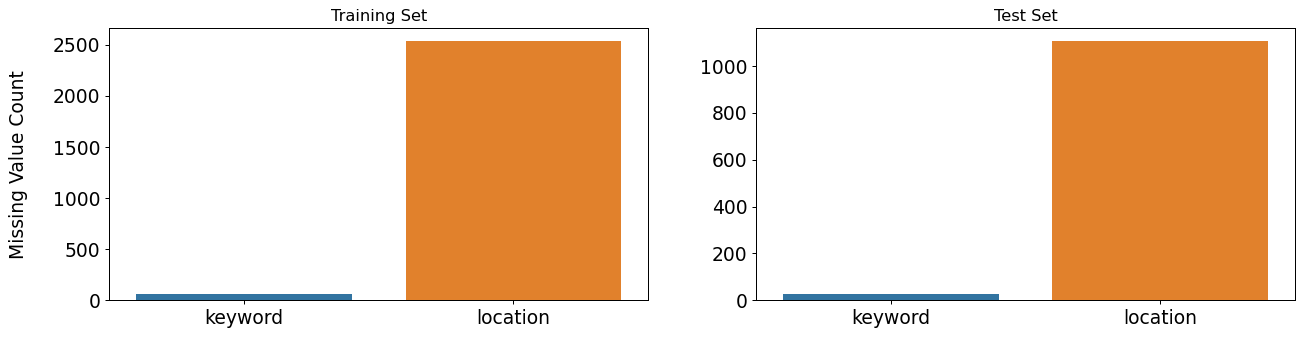

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=90)
missing_cols = ['keyword', 'location']
sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

#### Which type of these columns

In [7]:
pd.DataFrame({'count_NA': df_train.isna().sum(), 
              '%NA': round(100*df_train.isna().sum() / df_train.shape[0], 2), 
              'type' : df_train.dtypes})

,count_NA,%NA,type
id,0,0.00,int16
keyword,61,0.80,object
location,2533,33.27,object
text,0,0.00,object
target,0,0.00,int8


and for the `test.csv`

In [8]:
pd.DataFrame({'count_NA': df_test.isna().sum(), 
              '%NA': round(100*df_test.isna().sum() / df_test.shape[0], 2), 
              'type' : df_test.dtypes})

,count_NA,%NA,type
id,0,0.00,int16
keyword,26,0.80,object
location,1105,33.86,object
text,0,0.00,object


#### Comment.
- For the column `keyword`, it takes about `0.8%` at both dataset; whilethe column `location` is more than `33%`. Hence the missing value ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.
- The rest columns `id, text, target` (in `train.csv`) and `id, text` (in `test.csv`) has no missing value since we will predict the `target` (and add them to the `test`) mainly based on the `text`.

**Fill the missing values**

In [9]:
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')
df_train.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


### 1.2. Counting the unique values
#### The unique-values.

In [10]:
count_unique = [len(df_train[col].unique()) for col in df_train.columns]
percent_uniq = [round(100*cnt / df_train.shape[0], 2) for cnt in count_unique]
pd.DataFrame({'cnt_uniq': count_unique, 'perc_uniq_%': percent_uniq}, index = df_train.columns)

,cnt_uniq,perc_uniq_%
id,7613,100.00
keyword,222,2.92
location,3342,43.90
text,7503,98.56
target,2,0.03


#### Summarized the unique-values on the 2 datasets. 

In [11]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


### Target distribution.
- `Locations` are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.
- Fortunately, there is signal in `keyword` because some of those words can only be used in one context. `Keywords` have very different `tweet` counts and `target means`. 
- `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on keyword.

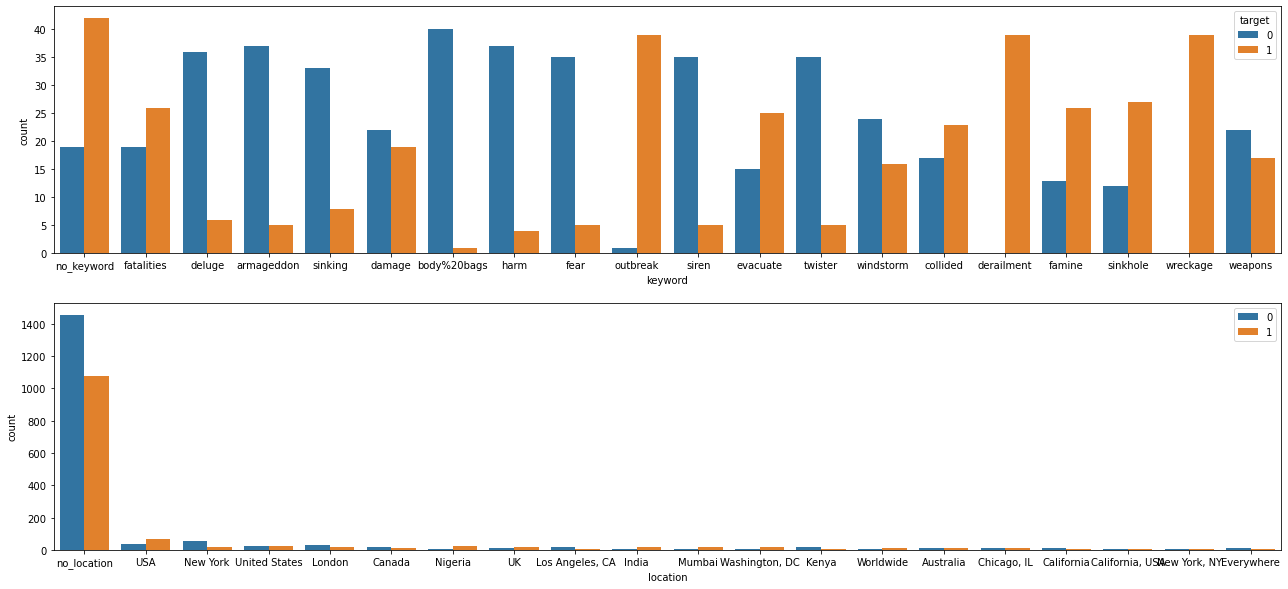

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (22, 10))
for k, x in enumerate(["keyword", "location"]):
    sns.countplot(x = x, 
                  hue = "target", 
                  data = df_train,
                  orient = "h",
                  order = df_train[x].value_counts().iloc[:20].index,
                  ax = ax[k])
    plt.legend(loc=1)

### 1.3. Target mean

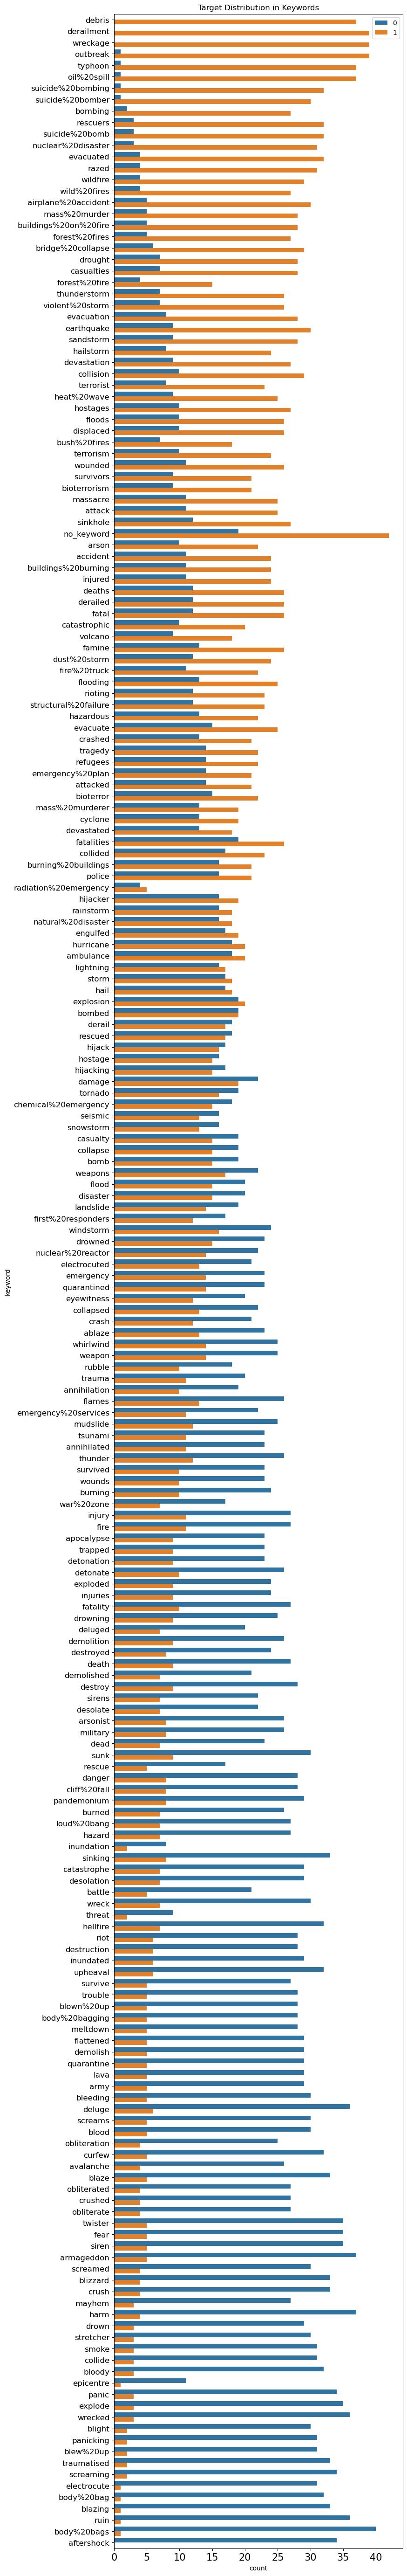

In [13]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Noting that, in the `train.csv`, we only have the `id` is the `integer` but it is used to assigned the index (it is not a `quantitative attribute`). Hence, we will only focus on the analysis the relation of the **Qualitative Attributes.**
### 1.4. Counting on the target.

Class distributions are **57%** for **0** (Not Disaster) and **43%** for **1** (Disaster). Classes are almost equally separated so they don't require any stratification by `target` in cross-validation.

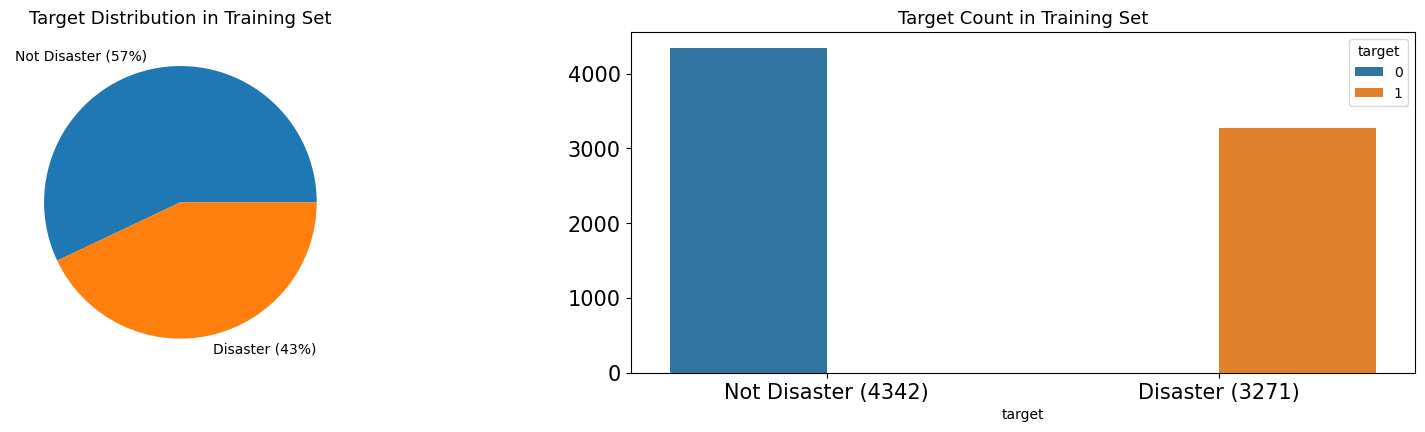

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

### 1.5. Meta-Features
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [15]:
df_train, df_test = enhanced_data(df_train, df_test)

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets. Those features might be useful in models.

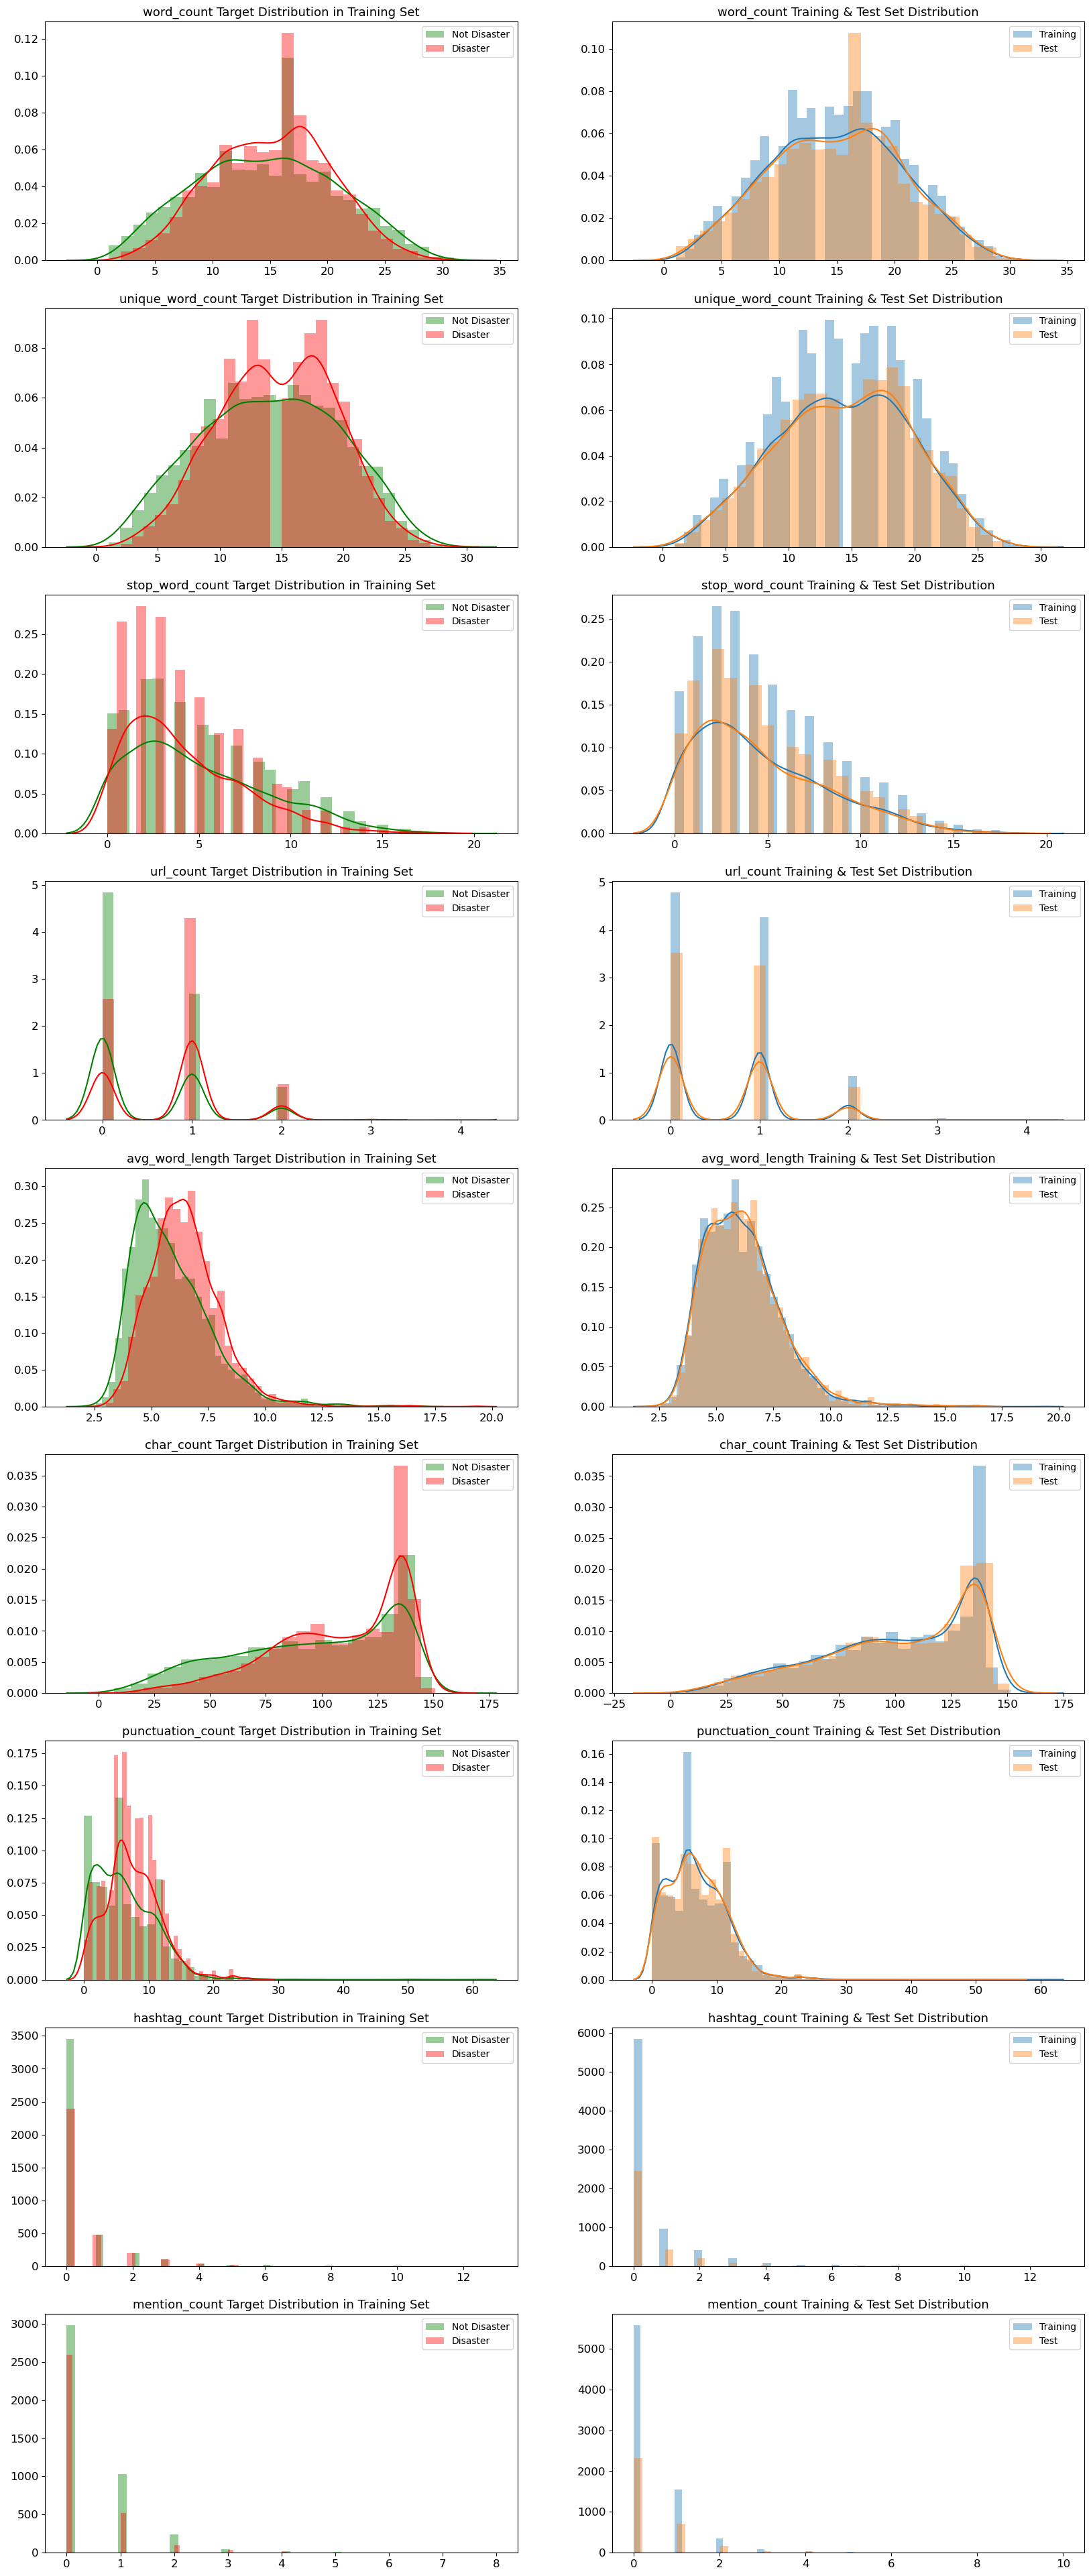

In [16]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'avg_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1
fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    if i < len(METAFEATURES) - 2:
        sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
        sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

        sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
        sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    else:
        sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], kde = False, label='Not Disaster', ax=axes[i][0], color='green')
        sns.distplot(df_train.loc[DISASTER_TWEETS][feature], kde = False, label='Disaster', ax=axes[i][0], color='red')
        sns.distplot(df_train[feature], kde = False, label='Training', ax=axes[i][1])
        sns.distplot(df_test[feature], kde = False, label='Test', ax=axes[i][1])
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

### 2. N-Grams Analysis
- Ngrams,
- Here, we will focus on the top $N$ (may be 10, 50, 100, 200, etc) `N-grams` in both `disaster_Ngrams` and `non-disaster_Ngrams`

Now, we firstly find the `N-grams` in the `text` of `train.csv` with the creating function `generate_ngrams`

In [17]:
N = 120

df_disaster_unigrams, df_nondisaster_unigrams = Ngrams_generate(DISASTER_TWEETS, df_train, ngram=1)
df_disaster_bigrams, df_nondisaster_bigrams = Ngrams_generate(DISASTER_TWEETS, df_train, ngram=2)
df_disaster_trigrams, df_nondisaster_trigrams = Ngrams_generate(DISASTER_TWEETS, df_train, ngram=3)

### 2.1. Unigrams.
Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

- Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.
- Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

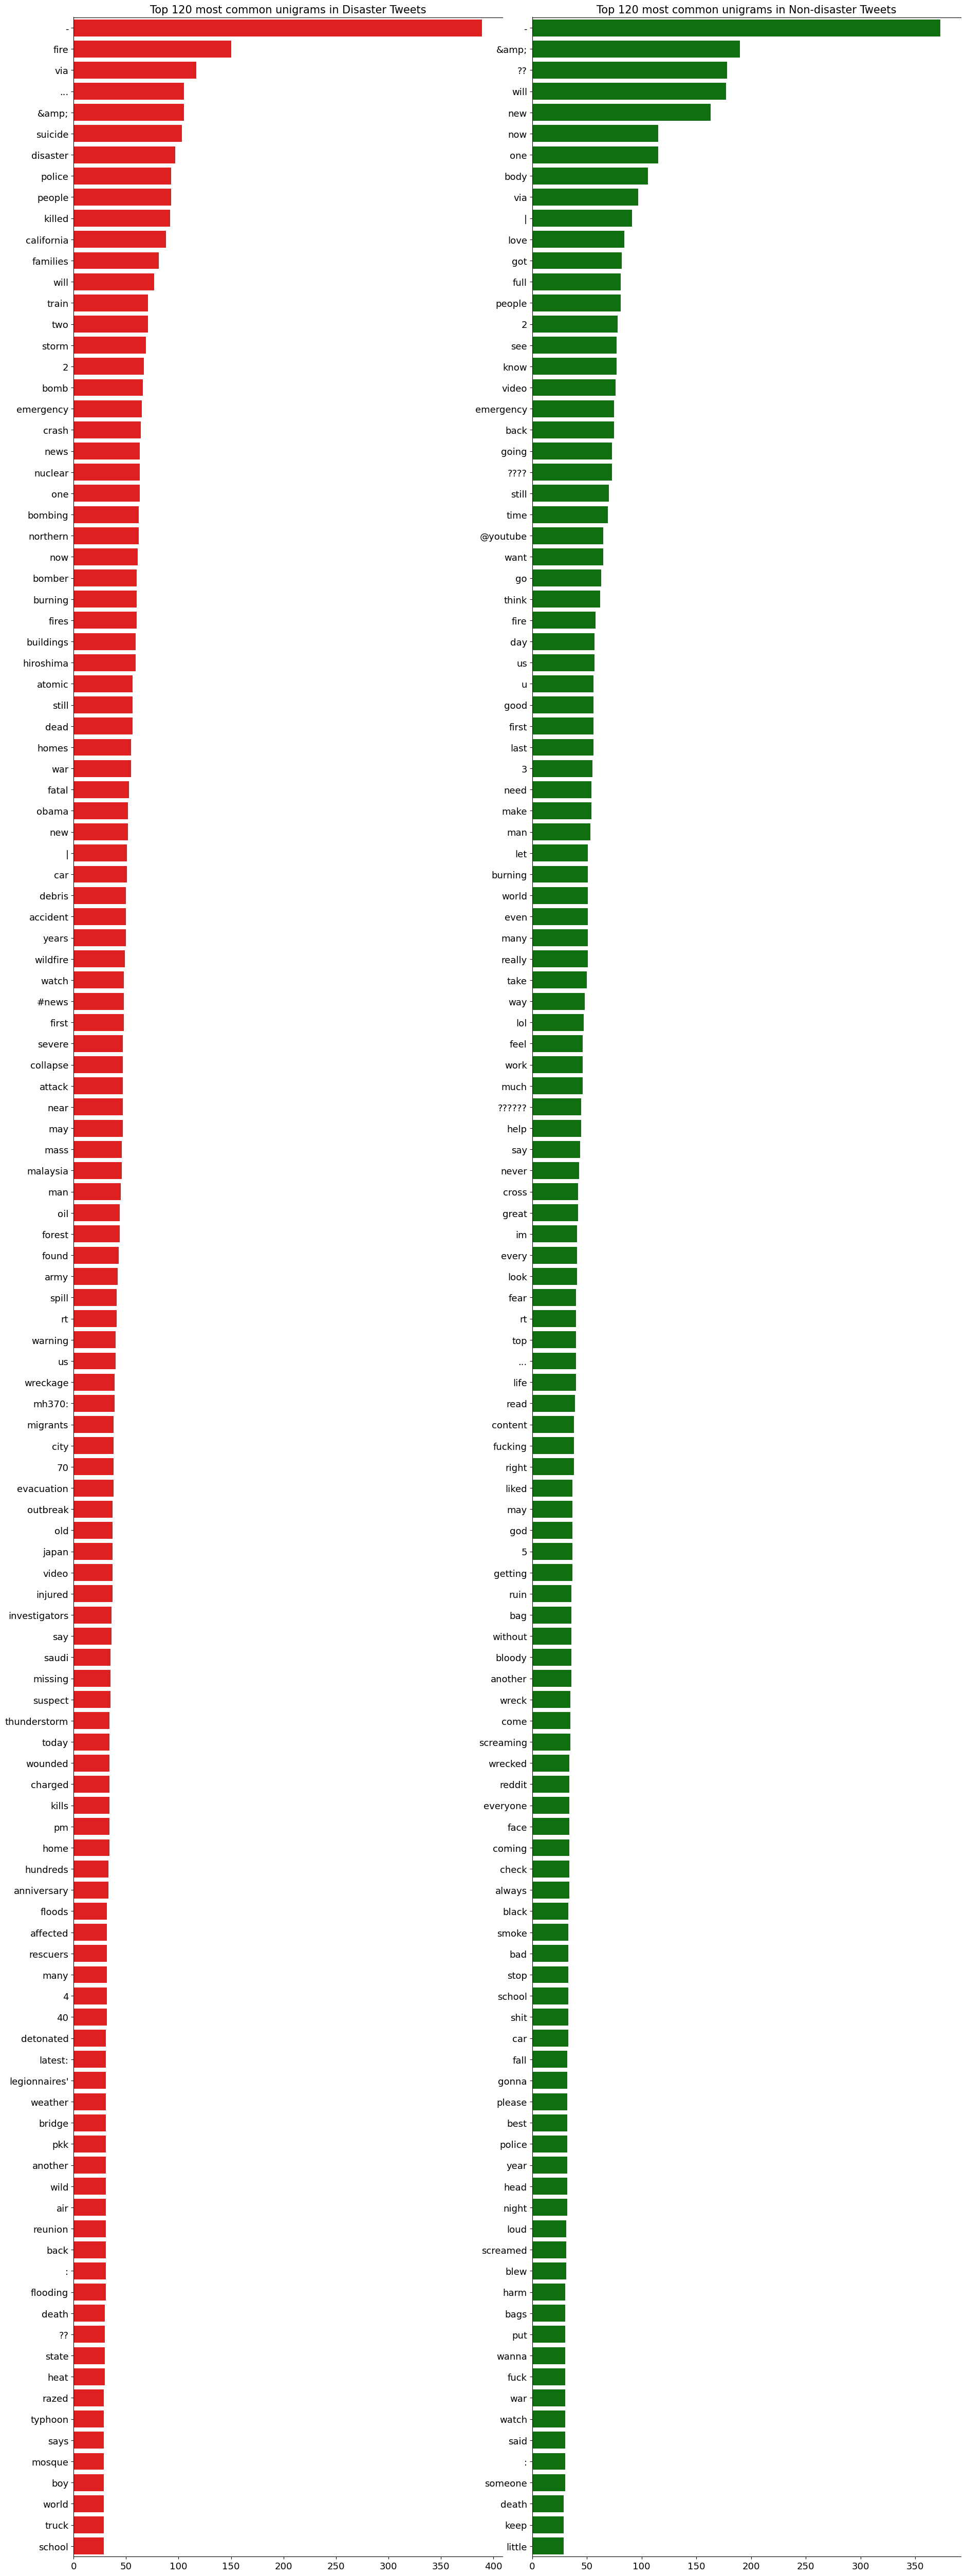

In [18]:
ngram_show(df_disaster_unigrams, df_nondisaster_unigrams, n_gram=1, top_N=N, figsize=(18, 50))

### 2.2. Bigrams
There are no common bigrams exist in **both classes**  because the context is clearer.

- Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

- Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

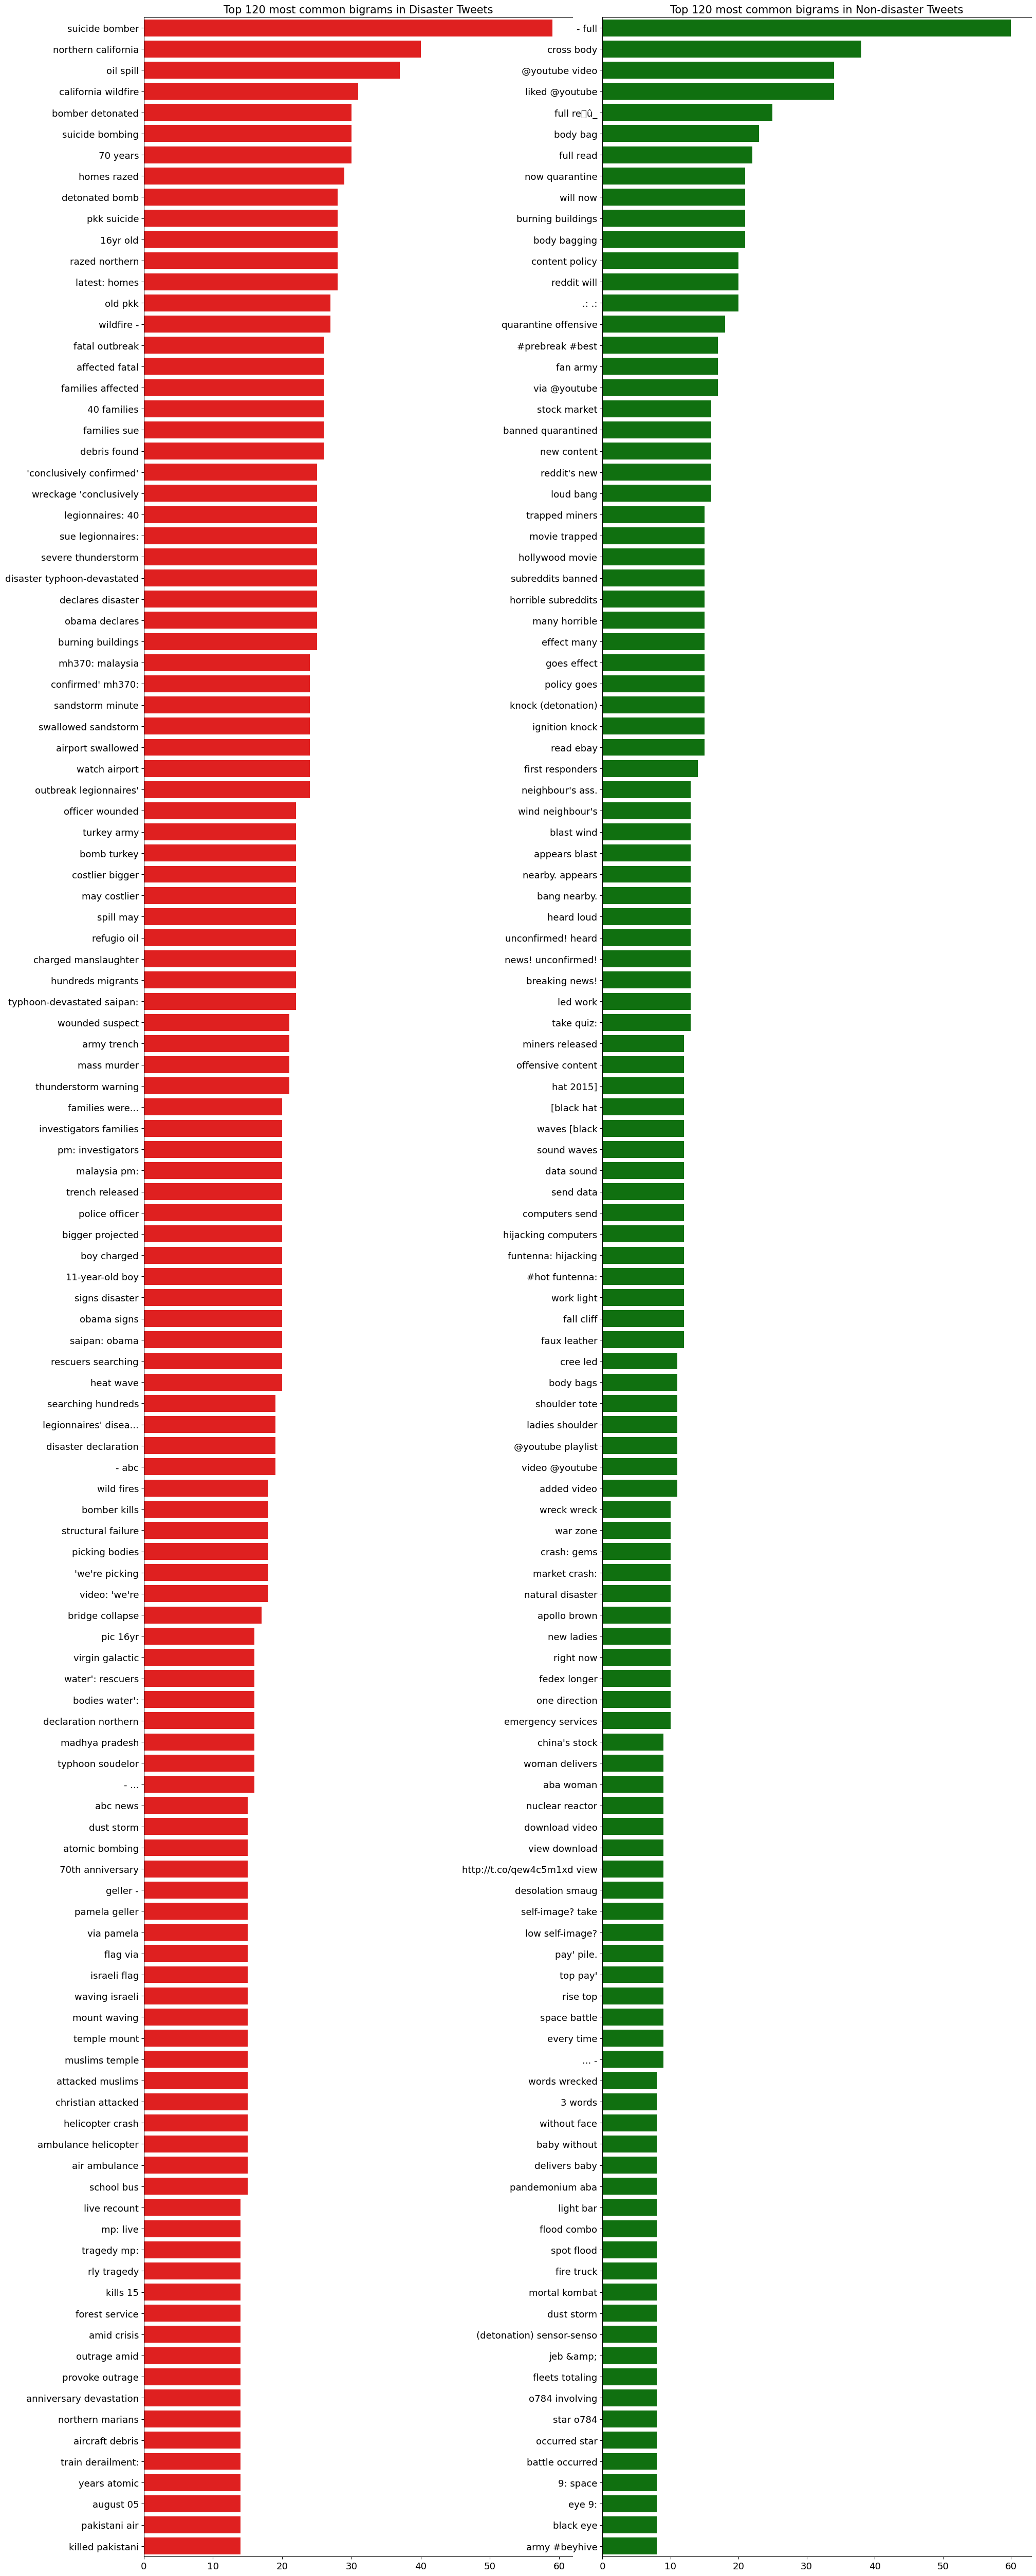

In [20]:
ngram_show(df_disaster_bigrams, df_nondisaster_bigrams, n_gram=1, top_N=N, figsize=(18, 50))

### 2.3. Tri-grams
There are no common trigrams exist in **both classes**  because the context is clearer.

Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

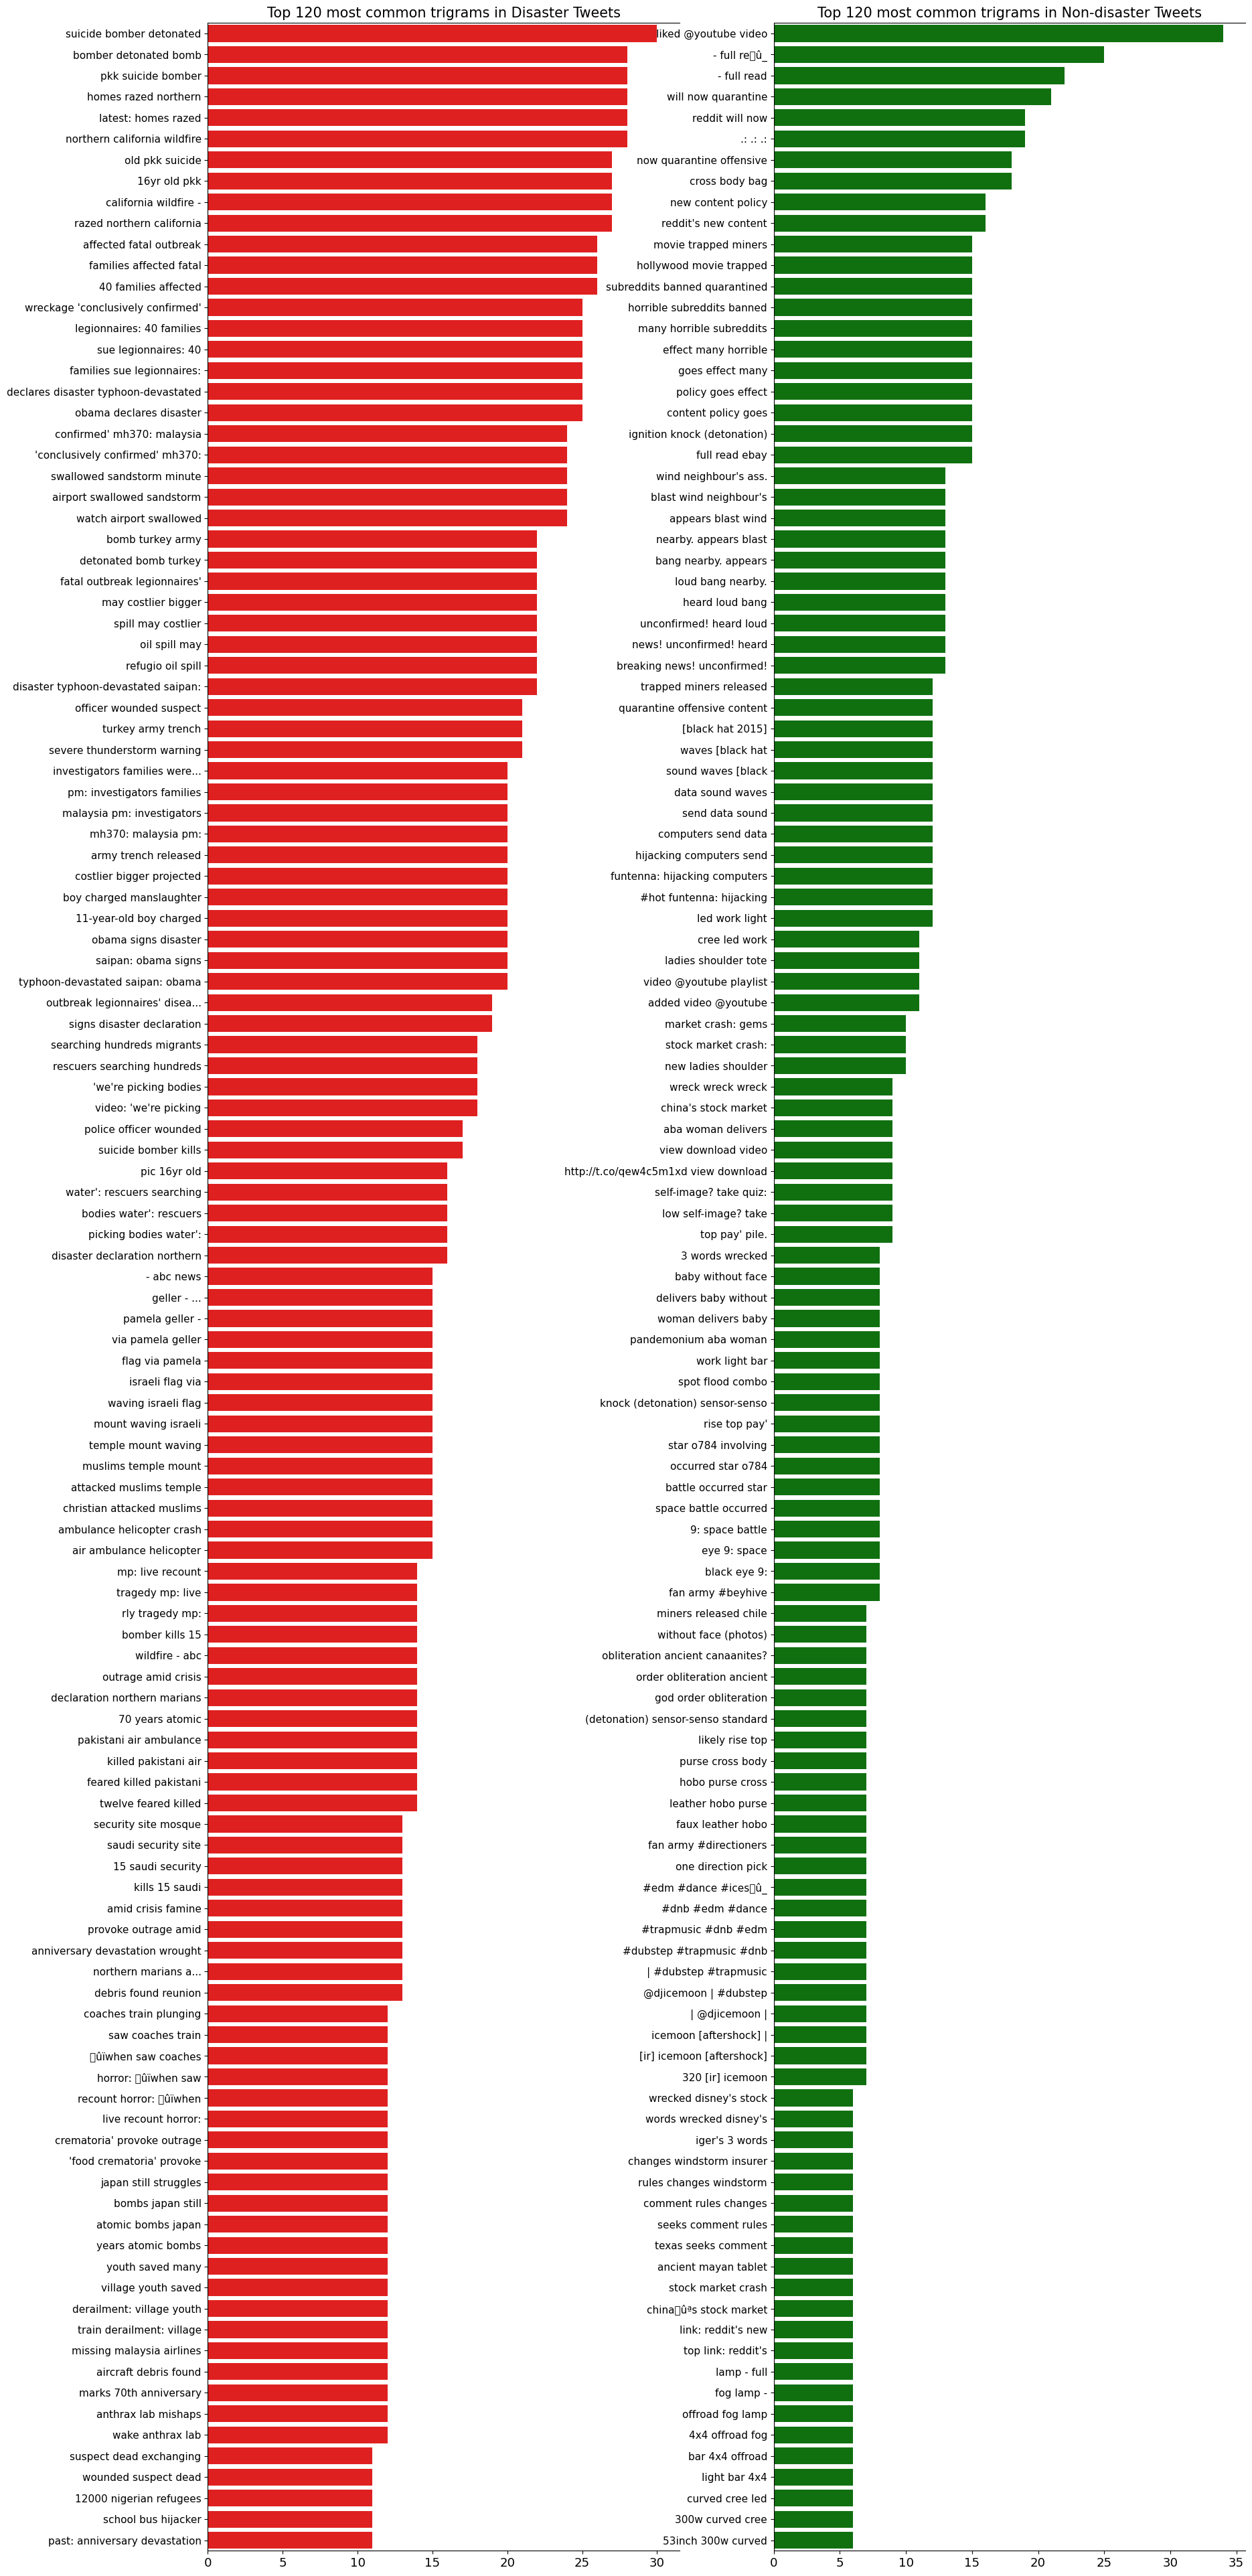

In [21]:
ngram_show(df_disaster_trigrams, df_nondisaster_trigrams, n_gram=1, top_N=N, figsize=(20, 50))

### 3. Cleaning text
Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

* The most common type of words that require cleaning in `oov` have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations `#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;` are separated from words
* Special characters that are attached to words are removed completely
* Contractions are expanded
* Urls are removed
* Character entity references are replaced with their actual symbols
* Typos and slang are corrected, and informal abbreviations are written in their long forms
* Some words are replaced with their acronyms and some words are grouped into one
* Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run `clean` function after adding those replace calls.

In [22]:
df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))
df_train.head()

CPU times: user 8min 5s, sys: 101 ms, total: 8min 5s
Wall time: 8min 5s


,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,avg_word_length,char_count,punctuation_count,hashtag_count,mention_count,text_cleaned
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0,Our Deeds are the Reason of this # earthquake...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0,Forest fire near La Ronge Sask . Canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,All residents asked to ' shelter in place ' ...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,"13,000 people receive # wildfires evacuation ..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,Just got sent this photo from Ruby # Alaska a...
